In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pdb
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import umap
import itertools
import time
import glob
import pickle
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from matplotlib import cm
import matplotlib.colors as mcolors

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axisartist.axislines import AxesZero
import matplotlib.cm as cm
import matplotlib.colors as colors

from collections import defaultdict
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import apply_df_filters, calc_loadings, calc_cascaded_loadings
from loaders import load_sabes
from decoders import lr_decoder
from segmentation import reach_segment_sabes, measure_straight_dev
#from psth_ilmerge import get_top_neurons, get_top_neurons_alt

/home/marcush/Data/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = '/home/marcush/Data/TsaoLabData/neural_control_output_new/dimreduc_deg_230322_214006_Jamie/dimreduc_deg_230322_214006_Jamie_glom.pickle'
with open(path, 'rb') as f:
    dat = pickle.load(f) 

df_dimreduc = pd.DataFrame(dat)

In [3]:
path = '/home/marcush/Data/TsaoLabData/neural_control_output_new/decoding_deg_230322_214006_Jamie/decoding_deg_230322_214006_Jamie_glom.pickle'
with open(path, 'rb') as f:
    dat = pickle.load(f) 

df_dec = pd.DataFrame(dat)

In [4]:
dimensions = np.unique(df_dimreduc['dim'])
n_folds = np.unique(df_dimreduc['fold_idx'])
regions = np.unique(df_dimreduc['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_dimreduc['dimreduc_method'])

In [8]:
ccamodel_dir = df_dimreduc['results_file'][0]
CCA_dims = 39 #None

if CCA_dims == None:
    ccamodel_path = glob.glob(ccamodel_dir+"/CCA_*.pickle")[0]
else:
    ccamodel_path = os.path.dirname(ccamodel_dir)+f"/CCA_{CCA_dims}_dims.pickle"

with open(ccamodel_path, 'rb') as file:
    ccamodel = pickle.load(file)

In [9]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
importance_scores = recursive_defaultdict()



for reg in regions:
    if reg == 'ML':
        cca_proj = ccamodel.x_rotations_
    else:
        cca_proj = ccamodel.y_rotations_

    for dim in dimensions:

        importance_scores[reg]['CCA'][dim] = calc_loadings(cca_proj[:, 0:dim])
        
        for method in dimreduc_methods:    
            all_scores = np.zeros((len(n_folds), cca_proj.shape[0]))

            for n_fold in n_folds:

                coef = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == reg)  & 
                                            (df_dimreduc['dim'] == dim) & (df_dimreduc['fold_idx'] == n_fold) &
                                            (df_dimreduc['dimreduc_method'] == method)]['coef'].iloc[0]
                
                all_scores[n_fold, :] = calc_loadings(coef)

            importance_scores[reg][method][dim] = np.mean(all_scores, 0)

In [10]:
def make_hashable(obj):
    if isinstance(obj, dict):
        return tuple(sorted((key, make_hashable(value)) for key, value in obj.items()))
    elif isinstance(obj, (list, tuple)):
        return tuple(make_hashable(item) for item in obj)
    else:
        return obj


unique_hashes = set(make_hashable(d) for d in df_dimreduc['full_arg_tuple'])
unique_dicts = [dict(u) for u in unique_hashes]
preload_dict_path = df_dimreduc['data_path'][0] + "/preloaded/preloadDict.pickle"

with open(preload_dict_path, 'rb') as file:
    preloadDict = pickle.load(file)

In [11]:
for arg_dict in unique_dicts:
    arg_tuple = tuple(sorted(arg_dict.items()))


    for args in preloadDict.keys():

        if args == arg_tuple:

            preloadID = preloadDict[arg_tuple]
            loaded_data_path = os.path.dirname(preload_dict_path) + f"/preloaded_data_{preloadID}.pickle"
            
            if arg_dict['region'] == 'AM':
                with open(loaded_data_path, 'rb') as file:
                    AM_loaded_data = pickle.load(file)

            elif arg_dict['region'] == 'ML':
                with open(loaded_data_path, 'rb') as file:
                    ML_loaded_data = pickle.load(file)

AM_avg_rates = np.mean(AM_loaded_data['spike_rates'], 0)
ML_avg_rates = np.mean(ML_loaded_data['spike_rates'], 0)

In [12]:
AM_numUnits = AM_loaded_data['NumUnits']
numTrials = AM_loaded_data['NumTrials']
SpikeMats_AM = AM_loaded_data['spike_times']
ML_numUnits = ML_loaded_data['NumUnits']
SpikeMats_ML = ML_loaded_data['spike_times']

bin_width = AM_loaded_data['bin_width']
num_bins = np.shape(AM_loaded_data['spike_rates'])[1]
trial_dur = num_bins * bin_width
num_trials = AM_loaded_data['NumTrials']

StimulusOFFDurations = AM_loaded_data['StimulusOFFDurations']
StimulusOnDurations = AM_loaded_data['StimulusOnDurations']
TrialDurations = StimulusOFFDurations + StimulusOnDurations
median_stim_on_time = int(np.median(StimulusOnDurations))

## Bin Responses

In [13]:
###################### Params
bin_size = 10
window = median_stim_on_time+120  # the time after which we'll look for baseline responses


print(f"Number of trials used to estimate baseline: {np.sum(TrialDurations > window)}")
num_bins = trial_dur // bin_size + (trial_dur % bin_size != 0)
bin_inds = np.arange(0, trial_dur, bin_size)

###################### Region AM
AM_binned_rates = np.zeros((numTrials, num_bins, AM_numUnits))
AM_baseline_means = np.zeros(AM_numUnits)
AM_baseline_stds = np.zeros(AM_numUnits)

for unit in np.arange(AM_numUnits):
    unit_baseline_responses = []

    for trial in np.arange(numTrials):

        # Get stimulus response rates
        sp_times = SpikeMats_ML[trial, unit][0]
        sp_times = sp_times[sp_times < trial_dur] 
        trial_raster = np.zeros(trial_dur)
        trial_raster[sp_times] = 1

        AM_binned_rates[trial, :, unit] = (np.add.reduceat(trial_raster, bin_inds) / bin_size) * 1000 # spikes/s


        # Get baseline response rates
        if TrialDurations[trial] > window: 
            sp_times_base = SpikeMats_ML[trial, unit][0]
            sp_times_base = sp_times_base[sp_times_base > window] - window # isolate baseline response

            base_raster = np.zeros( int(TrialDurations[trial]) - window )
            base_raster[sp_times_base] = 1

            base_inds = np.arange(0, len(base_raster), bin_size)
            binned_sums_baseline = np.add.reduceat(base_raster, base_inds)
            unit_baseline_responses = np.hstack((unit_baseline_responses,  binned_sums_baseline))
    
    AM_baseline_means[unit] = np.mean(unit_baseline_responses)
    AM_baseline_stds[unit] = np.std(unit_baseline_responses)


###################### Region ML
ML_binned_rates = np.zeros((numTrials, num_bins, ML_numUnits))
ML_baseline_means = np.zeros(ML_numUnits)
ML_baseline_stds = np.zeros(ML_numUnits)

for unit in np.arange(ML_numUnits):
    unit_baseline_responses = []

    for trial in np.arange(numTrials):

        # Get stimulus response rates
        sp_times = SpikeMats_ML[trial, unit][0]
        sp_times = sp_times[sp_times < trial_dur] 
        trial_raster = np.zeros(trial_dur)
        trial_raster[sp_times] = 1

        ML_binned_rates[trial, :, unit] = (np.add.reduceat(trial_raster, bin_inds) / bin_size) * 1000 # spikes/s


        # Get baseline response rates
        if TrialDurations[trial] > window: 
            sp_times_base = SpikeMats_ML[trial, unit][0]
            sp_times_base = sp_times_base[sp_times_base > window] - window # isolate baseline response

            base_raster = np.zeros( int(TrialDurations[trial]) - window )
            base_raster[sp_times_base] = 1

            base_inds = np.arange(0, len(base_raster), bin_size)
            binned_sums_baseline = np.add.reduceat(base_raster, base_inds)
            unit_baseline_responses = np.hstack((unit_baseline_responses,  binned_sums_baseline))
    
    ML_baseline_means[unit] = np.mean(unit_baseline_responses)
    ML_baseline_stds[unit] = np.std(unit_baseline_responses)


Number of trials used to estimate baseline: 1327


### Smooth Responses

In [14]:
smooth_kernel_size = 2
AM_binned_rates_smoothed = scipy.ndimage.gaussian_filter1d(AM_binned_rates, sigma = smooth_kernel_size, axis=1)
ML_binned_rates_smoothed = scipy.ndimage.gaussian_filter1d(ML_binned_rates, sigma = smooth_kernel_size, axis=1)


## Average Responses

In [15]:
all_rates_AM = np.mean(AM_binned_rates_smoothed, 0).T
all_rates_ML = np.mean(ML_binned_rates_smoothed, 0).T

### Plot Mean Responses

Text(0.5, 1.0, 'All Avg Firing Rates in ML')

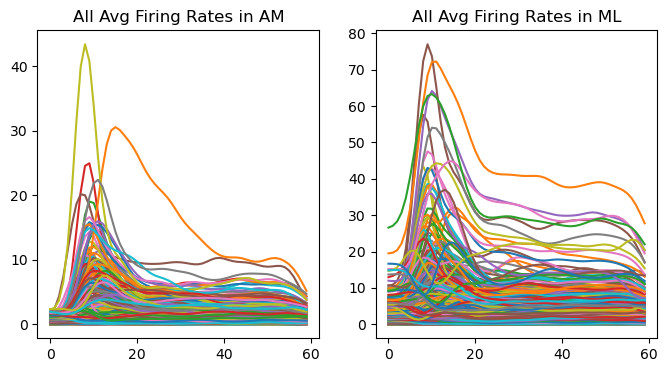

In [16]:
plot_window = [0, int((median_stim_on_time+80)/bin_size)+1]

plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
plt.plot(all_rates_AM[:, plot_window[0]:plot_window[-1]].T);
plt.title("All Avg Firing Rates in AM")


plt.subplot(1,2,2)
plt.plot(all_rates_ML[:, plot_window[0]:plot_window[-1]].T);
plt.title("All Avg Firing Rates in ML")

## Region AM

### Get importance scores

In [17]:
region = 'AM'
xall_stacked = all_rates_AM
DIM = 21  

FFC_scores = importance_scores[region]['PCA'][DIM]
FBC_scores = importance_scores[region]['LQGCA'][DIM]

rel_FBC_import = FBC_scores / (FBC_scores + FFC_scores)
rel_FFC_import = FFC_scores / (FBC_scores + FFC_scores)

### Use UMAP to reduce the dimension of the firing rate profiles (temporal dimension)

In [18]:
param = (4, 0.2, 50)
fit = umap.UMAP(min_dist=param[1], n_neighbors=param[2], n_components=param[0])
u = fit.fit_transform(xall_stacked)

### Use LDA to predict FBC vs FFC (using importance score) from U-Mapped response profile

In [19]:
fbc_fraction = np.linspace(0.5, 0.95, 25)
ncv = 5
nrandom = 100

scores = np.zeros((len(fbc_fraction), ncv))
dummy_scores = np.zeros((len(fbc_fraction), ncv))
random_scores = np.zeros((len(fbc_fraction), ncv, nrandom))

for ii, fbcf in tqdm(enumerate(fbc_fraction)):

    ntype = []

    rfbc = rel_FBC_import
    rffc = rel_FFC_import

    # do this by quantile
    cutoff = np.quantile(rfbc, fbcf)
    for n in range(rfbc.size):
        if rfbc[n] > cutoff:
            ntype.append(0)
        else:
            ntype.append(1)

    # get the
    lda = LinearDiscriminantAnalysis(n_components=1)
    # perform 10-fold cross-validation
    scores[ii] = cross_val_score(lda, u, ntype, cv=ncv)
    dummy_scores[ii] = cross_val_score(DummyClassifier(strategy='stratified'), u, ntype, cv=ncv)

    # Compare also to 100 random assignments of neuron types
    for k in range(nrandom):
        ntype_rand = np.random.permutation(ntype)
        random_scores[ii, :, k] = cross_val_score(lda, u, ntype_rand, cv=ncv)

0it [00:00, ?it/s]

25it [00:22,  1.11it/s]


### Save Values

In [21]:
with open(f'./response_profile_structs/response_profile_results_{region}.pkl', 'wb') as f:
    f.write(pickle.dumps(scores))
    f.write(pickle.dumps(dummy_scores))
    f.write(pickle.dumps(random_scores))

In [22]:
fbc_fraction = np.linspace(0.5, 0.95, 25)
with open(f'./response_profile_structs/response_profile_results_{region}.pkl', 'rb') as f:
    scores = pickle.load(f)
    dummy_scores = pickle.load(f)
    random_scores = pickle.load(f)


### Plot accuracy as a function of FFC vs FBC rel. importance score threshold

Text(0, 0.5, 'Classification Accuracy')

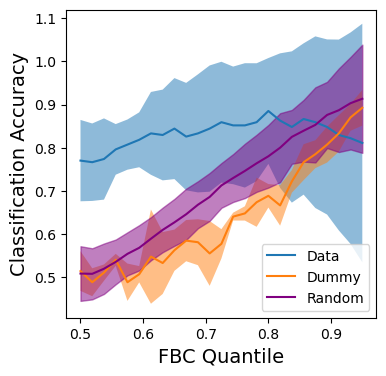

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(fbc_fraction, np.mean(scores, axis=(1)), label='Data')
ax.fill_between(fbc_fraction, np.mean(scores, axis=(1)) - np.std(scores, axis=(1)), np.mean(scores, axis=(1)) + np.std(scores, axis=(1)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(dummy_scores, axis=(1)), label='Dummy')
ax.fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1)) - np.std(dummy_scores, axis=(1)), np.mean(dummy_scores, axis=(1)) + np.std(dummy_scores, axis=(1)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(random_scores, axis=(1, 2)), label='Random', color='purple')
ax.fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2)) - np.std(random_scores, axis=(1, 2)), np.mean(random_scores, axis=(1, 2)) + np.std(random_scores, axis=(1, 2)), alpha=0.5, color='purple')

ax.legend(loc='lower right')
ax.set_xlabel('FBC Quantile', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)



# Project data onto first LDA dimension and inset above plot

In [24]:
fbcf = 0.5 # The threshold to use for determining classes (and then classifying with LDA)

ntype = []
rfbc = rel_FBC_import

cutoff = np.quantile(rfbc, fbcf)
for n in range(rfbc.size):
    if rfbc[n] > cutoff:
        ntype.append(0)
    else:
        ntype.append(1)
        
lda = LinearDiscriminantAnalysis(n_components=1)
xtrans = lda.fit_transform(u, ntype)

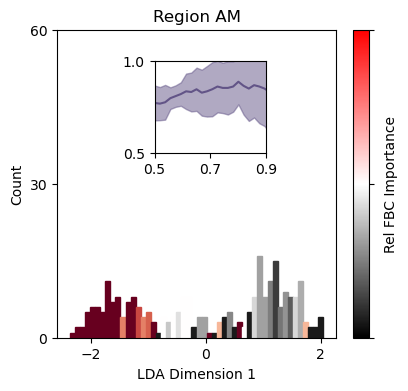

In [25]:
carray = cm.RdGy(range(256))

# Color by type
fig, ax = plt.subplots(figsize=(4.5, 4))
N, bins, patches = ax.hist(xtrans, linewidth=1, bins=50)
xbinned = np.digitize(xtrans, bins).squeeze()
# Set each rectangle to a color gradient set by the fraction of entries that belong to each type
for i in range(len(patches)):
    x_ = np.where(xbinned == i + 1)[0]
    ntype_ = np.array(ntype)[x_]

    if x_.size == 0:
        frac = 0 # just ignore these, since these will have no height anyways
    else:
        frac = np.sum(ntype_)/x_.size

    patches[i].set_facecolor(carray[int(255 * frac)])
    patches[i].set_edgecolor(carray[int(255 * frac)])
    #patches[i].set_facecolor(carray[0])
ax.set_xlabel('LDA Dimension 1')
ax.set_ylabel('Count')
ax.set_xticks([-2, 0, 2])
ax.set_yticks([0, 30, 60])
cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])
norm = colors.Normalize(vmin=0, vmax=1)
cbar= fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='Rel FBC Importance', ticks=[0, 0.5, 1.0])
#cbar.ax.set_yticks([0, 0.5, 1.0])
cbar.ax.set_yticklabels([])
plt.title("Region AM")


axin = ax.inset_axes([0.35, 0.6, 0.4, 0.3])
# axin.set_aspect(1)
axin.set_ylim([0.5, 1.0])
axin.set_xlim([0.5, 0.9])
axin.set_yticks([0.5, 1.0])
axin.set_xticks([0.5, 0.7, 0.9])
axin.plot(fbc_fraction, np.mean(scores, axis=(1)), color='#625487')
axin.fill_between(fbc_fraction, np.mean(scores, axis=(1)) - np.std(scores, axis=(1)), np.mean(scores, axis=(1)) + np.std(scores, axis=(1)), alpha=0.5, color='#625487')
#fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/s1_lda_viz.pdf', bbox_inches='tight', pad_inches=0)

# Region ML

### Get importance scores

In [26]:
region = 'ML'
xall_stacked = all_rates_ML

DIM = 21  

FFC_scores = importance_scores[region]['PCA'][DIM]
FBC_scores = importance_scores[region]['LQGCA'][DIM]

rel_FBC_import = FBC_scores / (FBC_scores + FFC_scores)
rel_FFC_import = FFC_scores / (FBC_scores + FFC_scores)

### Use UMAP to reduce the dimension of the firing rate profiles (temporal dimension)

In [27]:
param = (4, 0.2, 50)
fit = umap.UMAP(min_dist=param[1], n_neighbors=param[2], n_components=param[0])
u = fit.fit_transform(xall_stacked)

### Use LDA to predict FBC vs FFC (using importance score) from U-Mapped response profile

In [28]:
fbc_fraction = np.linspace(0.5, 0.95, 25)
ncv = 5
nrandom = 100

scores = np.zeros((len(fbc_fraction), ncv))
dummy_scores = np.zeros((len(fbc_fraction), ncv))
random_scores = np.zeros((len(fbc_fraction), ncv, nrandom))

for ii, fbcf in tqdm(enumerate(fbc_fraction)):

    ntype = []

    rfbc = rel_FBC_import
    rffc = rel_FFC_import

    # do this by quantile
    cutoff = np.quantile(rfbc, fbcf)
    for n in range(rfbc.size):
        if rfbc[n] > cutoff:
            ntype.append(0)
        else:
            ntype.append(1)

    # get the
    lda = LinearDiscriminantAnalysis(n_components=1)
    # perform 10-fold cross-validation
    scores[ii] = cross_val_score(lda, u, ntype, cv=ncv)
    dummy_scores[ii] = cross_val_score(DummyClassifier(strategy='stratified'), u, ntype, cv=ncv)

    # Compare also to 100 random assignments of neuron types
    for k in range(nrandom):
        ntype_rand = np.random.permutation(ntype)
        random_scores[ii, :, k] = cross_val_score(lda, u, ntype_rand, cv=ncv)

0it [00:00, ?it/s]

25it [00:29,  1.18s/it]


### Save Values

In [29]:
with open(f'./response_profile_structs/response_profile_results_{region}.pkl', 'wb') as f:
    f.write(pickle.dumps(scores))
    f.write(pickle.dumps(dummy_scores))
    f.write(pickle.dumps(random_scores))

In [30]:
fbc_fraction = np.linspace(0.5, 0.95, 25)
with open(f'./response_profile_structs/response_profile_results_{region}.pkl', 'rb') as f:
    scores = pickle.load(f)
    dummy_scores = pickle.load(f)
    random_scores = pickle.load(f)

### Plot accuracy as a function of FFC vs FBC rel. importance score threshold

Text(0, 0.5, 'Classification Accuracy')

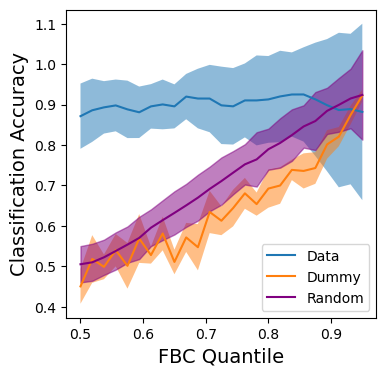

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(fbc_fraction, np.mean(scores, axis=(1)), label='Data')
ax.fill_between(fbc_fraction, np.mean(scores, axis=(1)) - np.std(scores, axis=(1)), np.mean(scores, axis=(1)) + np.std(scores, axis=(1)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(dummy_scores, axis=(1)), label='Dummy')
ax.fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1)) - np.std(dummy_scores, axis=(1)), np.mean(dummy_scores, axis=(1)) + np.std(dummy_scores, axis=(1)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(random_scores, axis=(1, 2)), label='Random', color='purple')
ax.fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2)) - np.std(random_scores, axis=(1, 2)), np.mean(random_scores, axis=(1, 2)) + np.std(random_scores, axis=(1, 2)), alpha=0.5, color='purple')

ax.legend(loc='lower right')
ax.set_xlabel('FBC Quantile', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)



# Project data onto first LDA dimension and inset above plot

In [32]:
fbcf = 0.5 # The threshold to use for determining classes (and then classifying with LDA)

ntype = []
rfbc = rel_FBC_import

cutoff = np.quantile(rfbc, fbcf)
for n in range(rfbc.size):
    if rfbc[n] > cutoff:
        ntype.append(0)
    else:
        ntype.append(1)
        
lda = LinearDiscriminantAnalysis(n_components=1)
xtrans = lda.fit_transform(u, ntype)

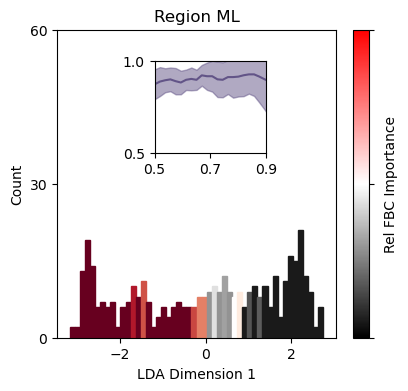

In [33]:
carray = cm.RdGy(range(256))

# Color by type
fig, ax = plt.subplots(figsize=(4.5, 4))
N, bins, patches = ax.hist(xtrans, linewidth=1, bins=50)
xbinned = np.digitize(xtrans, bins).squeeze()
# Set each rectangle to a color gradient set by the fraction of entries that belong to each type
for i in range(len(patches)):
    x_ = np.where(xbinned == i + 1)[0]
    ntype_ = np.array(ntype)[x_]

    if x_.size == 0:
        frac = 0 # just ignore these, since these will have no height anyways
    else:
        frac = np.sum(ntype_)/x_.size

    patches[i].set_facecolor(carray[int(255 * frac)])
    patches[i].set_edgecolor(carray[int(255 * frac)])
    #patches[i].set_facecolor(carray[0])
ax.set_xlabel('LDA Dimension 1')
ax.set_ylabel('Count')
ax.set_xticks([-2, 0, 2])
ax.set_yticks([0, 30, 60])
cmap = mcolors.LinearSegmentedColormap.from_list('black_white_red', ['black', 'white', 'red'])
norm = colors.Normalize(vmin=0, vmax=1)
cbar= fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='Rel FBC Importance', ticks=[0, 0.5, 1.0])
#cbar.ax.set_yticks([0, 0.5, 1.0])
cbar.ax.set_yticklabels([])
plt.title("Region ML")


axin = ax.inset_axes([0.35, 0.6, 0.4, 0.3])
# axin.set_aspect(1)
axin.set_ylim([0.5, 1.0])
axin.set_xlim([0.5, 0.9])
axin.set_yticks([0.5, 1.0])
axin.set_xticks([0.5, 0.7, 0.9])
axin.plot(fbc_fraction, np.mean(scores, axis=(1)), color='#625487')
axin.fill_between(fbc_fraction, np.mean(scores, axis=(1)) - np.std(scores, axis=(1)), np.mean(scores, axis=(1)) + np.std(scores, axis=(1)), alpha=0.5, color='#625487')
#fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/s1_lda_viz.pdf', bbox_inches='tight', pad_inches=0)

# SCRAPS: Could consider doing this on waveforms

In [89]:
preload_dict_path = df_dimreduc['data_path'][0] + "/preloaded/preloadDict.pickle"

with open(preload_dict_path, 'rb') as file:
    preloadDict = pickle.load(file)


for arg_dict in unique_dicts:
    arg_tuple = tuple(sorted(arg_dict.items()))


    for args in preloadDict.keys():

        if args == arg_tuple:

            preloadID = preloadDict[arg_tuple]
            loaded_data_path = os.path.dirname(preload_dict_path) + f"/preloaded_data_{preloadID}.pickle"
            
            if arg_dict['region'] == 'AM':
                with open(loaded_data_path, 'rb') as file:
                    AM_loaded_data = pickle.load(file)

            elif arg_dict['region'] == 'ML':
                with open(loaded_data_path, 'rb') as file:
                    ML_loaded_data = pickle.load(file)

### Region ML

In [95]:
ML_waveforms = ML_loaded_data['waveforms']


xall_stacked = ML_waveforms
region = 'ML'
DIM = 21  


param = (4, 0.2, 50)
fit = umap.UMAP(min_dist=param[1], n_neighbors=param[2], n_components=param[0])
u = fit.fit_transform(xall_stacked)

0it [00:00, ?it/s]

25it [01:39,  3.97s/it]


Text(0, 0.5, 'Classification Accuracy')

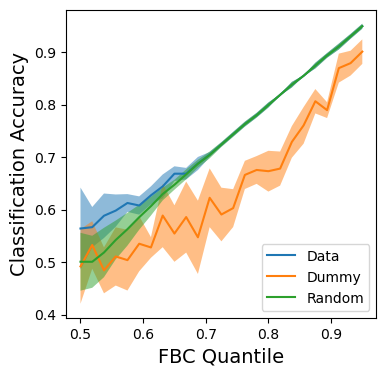

In [96]:
FFC_scores = importance_scores[region]['PCA'][DIM]
FBC_scores = importance_scores[region]['LQGCA'][DIM]

rel_FBC_import = FBC_scores / (FBC_scores + FFC_scores)
rel_FFC_import = FFC_scores / (FBC_scores + FFC_scores)

fbc_fraction = np.linspace(0.5, 0.95, 25)
ncv = 5
nrandom = 100

scores = np.zeros((len(fbc_fraction), ncv))
dummy_scores = np.zeros((len(fbc_fraction), ncv))
random_scores = np.zeros((len(fbc_fraction), ncv, nrandom))

for ii, fbcf in tqdm(enumerate(fbc_fraction)):

    ntype = []

    rfbc = rel_FBC_import
    rffc = rel_FFC_import

    # do this by quantile
    cutoff = np.quantile(rfbc, fbcf)
    for n in range(rfbc.size):
        if rfbc[n] > cutoff:
            ntype.append(0)
        else:
            ntype.append(1)

    # get the
    logreg = LogisticRegression()
    # perform 10-fold cross-validation
    scores[ii] = cross_val_score(logreg, u, ntype, cv=ncv)
    dummy_scores[ii] = cross_val_score(DummyClassifier(strategy='stratified'), u, ntype, cv=ncv)

    # Compare also to 100 random assignments of neuron types
    for k in range(nrandom):
        ntype_rand = np.random.permutation(ntype)
        random_scores[ii, :, k] = cross_val_score(logreg, u, ntype_rand, cv=ncv)



fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(fbc_fraction, np.mean(scores, axis=(1)), label='Data')
ax.fill_between(fbc_fraction, np.mean(scores, axis=(1)) - np.std(scores, axis=(1)), np.mean(scores, axis=(1)) + np.std(scores, axis=(1)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(dummy_scores, axis=(1)), label='Dummy')
ax.fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1)) - np.std(dummy_scores, axis=(1)), np.mean(dummy_scores, axis=(1)) + np.std(dummy_scores, axis=(1)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(random_scores, axis=(1, 2)), label='Random')
ax.fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2)) - np.std(random_scores, axis=(1, 2)), np.mean(random_scores, axis=(1, 2)) + np.std(random_scores, axis=(1, 2)), alpha=0.5)

ax.legend(loc='lower right')
ax.set_xlabel('FBC Quantile', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)

0it [00:00, ?it/s]

25it [00:33,  1.33s/it]


Text(0, 0.5, 'Classification Accuracy')

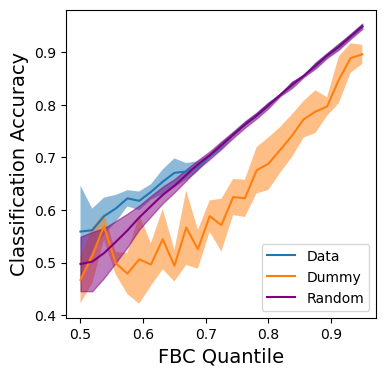

In [97]:
fbc_fraction = np.linspace(0.5, 0.95, 25)
ncv = 5
nrandom = 100

scores = np.zeros((len(fbc_fraction), ncv))
dummy_scores = np.zeros((len(fbc_fraction), ncv))
random_scores = np.zeros((len(fbc_fraction), ncv, nrandom))

for ii, fbcf in tqdm(enumerate(fbc_fraction)):

    ntype = []

    rfbc = rel_FBC_import
    rffc = rel_FFC_import

    # do this by quantile
    cutoff = np.quantile(rfbc, fbcf)
    for n in range(rfbc.size):
        if rfbc[n] > cutoff:
            ntype.append(0)
        else:
            ntype.append(1)

    # get the
    lda = LinearDiscriminantAnalysis(n_components=1)
    # perform 10-fold cross-validation
    scores[ii] = cross_val_score(lda, u, ntype, cv=ncv)
    dummy_scores[ii] = cross_val_score(DummyClassifier(strategy='stratified'), u, ntype, cv=ncv)

    # Compare also to 100 random assignments of neuron types
    for k in range(nrandom):
        ntype_rand = np.random.permutation(ntype)
        random_scores[ii, :, k] = cross_val_score(lda, u, ntype_rand, cv=ncv)


fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(fbc_fraction, np.mean(scores, axis=(1)), label='Data')
ax.fill_between(fbc_fraction, np.mean(scores, axis=(1)) - np.std(scores, axis=(1)), np.mean(scores, axis=(1)) + np.std(scores, axis=(1)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(dummy_scores, axis=(1)), label='Dummy')
ax.fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1)) - np.std(dummy_scores, axis=(1)), np.mean(dummy_scores, axis=(1)) + np.std(dummy_scores, axis=(1)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(random_scores, axis=(1, 2)), label='Random', color='purple')
ax.fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2)) - np.std(random_scores, axis=(1, 2)), np.mean(random_scores, axis=(1, 2)) + np.std(random_scores, axis=(1, 2)), alpha=0.5, color='purple')

ax.legend(loc='lower right')
ax.set_xlabel('FBC Quantile', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)

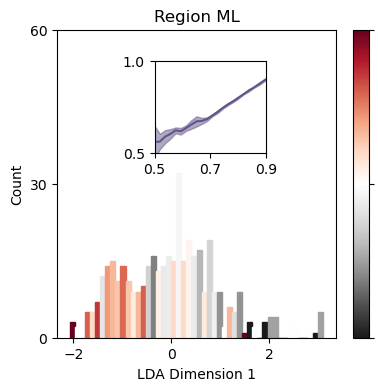

In [98]:
fbcf = 0.5

ntype = []
rfbc = rel_FBC_import

cutoff = np.quantile(rfbc, fbcf)
for n in range(rfbc.size):
    if rfbc[n] > cutoff:
        ntype.append(0)
    else:
        ntype.append(1)


lda = LinearDiscriminantAnalysis(n_components=1)
xtrans = lda.fit_transform(u, ntype)

carray = cm.RdGy(range(256))

# Color by type
fig, ax = plt.subplots(figsize=(4.5, 4))
N, bins, patches = ax.hist(xtrans, linewidth=1, bins=50)
xbinned = np.digitize(xtrans, bins).squeeze()
# Set each rectangle to a color gradient set by the fraction of entries that belong to each type
for i in range(len(patches)):
    x_ = np.where(xbinned == i + 1)[0]
    ntype_ = np.array(ntype)[x_]

    if x_.size == 0:
        frac = 0 # just ignore these, since these will have no height anyways
    else:
        frac = np.sum(ntype_)/x_.size

    patches[i].set_facecolor(carray[int(255 * frac)])
    patches[i].set_edgecolor(carray[int(255 * frac)])
    #patches[i].set_facecolor(carray[0])
ax.set_xlabel('LDA Dimension 1')
ax.set_ylabel('Count')
ax.set_xticks([-2, 0, 2])
ax.set_yticks([0, 30, 60])
cmap = cm.RdGy.reversed()
norm = colors.Normalize(vmin=0, vmax=1)
cbar= fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='', ticks=[0, 0.5, 1.0])
#cbar.ax.set_yticks([0, 0.5, 1.0])
cbar.ax.set_yticklabels([])
plt.title("Region ML")


axin = ax.inset_axes([0.35, 0.6, 0.4, 0.3])
# axin.set_aspect(1)
axin.set_ylim([0.5, 1.0])
axin.set_xlim([0.5, 0.9])
axin.set_yticks([0.5, 1.0])
axin.set_xticks([0.5, 0.7, 0.9])
axin.plot(fbc_fraction, np.mean(scores, axis=(1)), color='#625487')
axin.fill_between(fbc_fraction, np.mean(scores, axis=(1)) - np.std(scores, axis=(1)), np.mean(scores, axis=(1)) + np.std(scores, axis=(1)), alpha=0.5, color='#625487')

## Region AM

In [100]:
AM_waveforms = AM_loaded_data['waveforms']


xall_stacked = AM_waveforms
region = 'AM'
DIM = 21  

param = (4, 0.2, 50)
fit = umap.UMAP(min_dist=param[1], n_neighbors=param[2], n_components=param[0])
u = fit.fit_transform(xall_stacked)

0it [00:00, ?it/s]

25it [01:27,  3.50s/it]


Text(0, 0.5, 'Classification Accuracy')

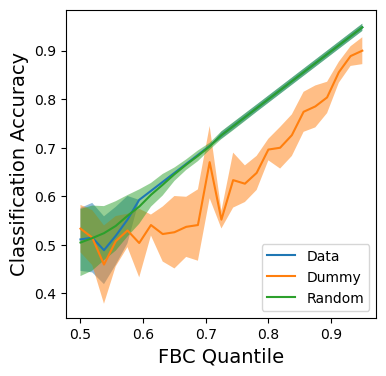

In [101]:
FFC_scores = importance_scores[region]['PCA'][DIM]
FBC_scores = importance_scores[region]['LQGCA'][DIM]

rel_FBC_import = FBC_scores / (FBC_scores + FFC_scores)
rel_FFC_import = FFC_scores / (FBC_scores + FFC_scores)

fbc_fraction = np.linspace(0.5, 0.95, 25)
ncv = 5
nrandom = 100

scores = np.zeros((len(fbc_fraction), ncv))
dummy_scores = np.zeros((len(fbc_fraction), ncv))
random_scores = np.zeros((len(fbc_fraction), ncv, nrandom))

for ii, fbcf in tqdm(enumerate(fbc_fraction)):

    ntype = []

    rfbc = rel_FBC_import
    rffc = rel_FFC_import

    # do this by quantile
    cutoff = np.quantile(rfbc, fbcf)
    for n in range(rfbc.size):
        if rfbc[n] > cutoff:
            ntype.append(0)
        else:
            ntype.append(1)

    # get the
    logreg = LogisticRegression()
    # perform 10-fold cross-validation
    scores[ii] = cross_val_score(logreg, u, ntype, cv=ncv)
    dummy_scores[ii] = cross_val_score(DummyClassifier(strategy='stratified'), u, ntype, cv=ncv)

    # Compare also to 100 random assignments of neuron types
    for k in range(nrandom):
        ntype_rand = np.random.permutation(ntype)
        random_scores[ii, :, k] = cross_val_score(logreg, u, ntype_rand, cv=ncv)



fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(fbc_fraction, np.mean(scores, axis=(1)), label='Data')
ax.fill_between(fbc_fraction, np.mean(scores, axis=(1)) - np.std(scores, axis=(1)), np.mean(scores, axis=(1)) + np.std(scores, axis=(1)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(dummy_scores, axis=(1)), label='Dummy')
ax.fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1)) - np.std(dummy_scores, axis=(1)), np.mean(dummy_scores, axis=(1)) + np.std(dummy_scores, axis=(1)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(random_scores, axis=(1, 2)), label='Random')
ax.fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2)) - np.std(random_scores, axis=(1, 2)), np.mean(random_scores, axis=(1, 2)) + np.std(random_scores, axis=(1, 2)), alpha=0.5)

ax.legend(loc='lower right')
ax.set_xlabel('FBC Quantile', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)

0it [00:00, ?it/s]

25it [00:31,  1.26s/it]


Text(0, 0.5, 'Classification Accuracy')

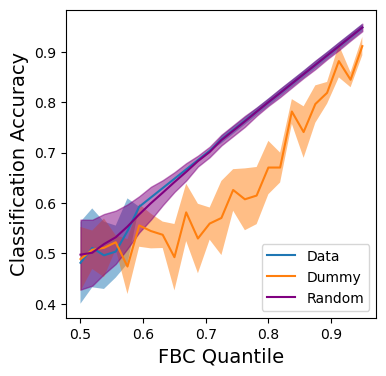

In [102]:

fbc_fraction = np.linspace(0.5, 0.95, 25)
ncv = 5
nrandom = 100

scores = np.zeros((len(fbc_fraction), ncv))
dummy_scores = np.zeros((len(fbc_fraction), ncv))
random_scores = np.zeros((len(fbc_fraction), ncv, nrandom))

for ii, fbcf in tqdm(enumerate(fbc_fraction)):

    ntype = []

    rfbc = rel_FBC_import
    rffc = rel_FFC_import

    # do this by quantile
    cutoff = np.quantile(rfbc, fbcf)
    for n in range(rfbc.size):
        if rfbc[n] > cutoff:
            ntype.append(0)
        else:
            ntype.append(1)

    # get the
    lda = LinearDiscriminantAnalysis(n_components=1)
    # perform 10-fold cross-validation
    scores[ii] = cross_val_score(lda, u, ntype, cv=ncv)
    dummy_scores[ii] = cross_val_score(DummyClassifier(strategy='stratified'), u, ntype, cv=ncv)

    # Compare also to 100 random assignments of neuron types
    for k in range(nrandom):
        ntype_rand = np.random.permutation(ntype)
        random_scores[ii, :, k] = cross_val_score(lda, u, ntype_rand, cv=ncv)


fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(fbc_fraction, np.mean(scores, axis=(1)), label='Data')
ax.fill_between(fbc_fraction, np.mean(scores, axis=(1)) - np.std(scores, axis=(1)), np.mean(scores, axis=(1)) + np.std(scores, axis=(1)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(dummy_scores, axis=(1)), label='Dummy')
ax.fill_between(fbc_fraction, np.mean(dummy_scores, axis=(1)) - np.std(dummy_scores, axis=(1)), np.mean(dummy_scores, axis=(1)) + np.std(dummy_scores, axis=(1)), alpha=0.5)

ax.plot(fbc_fraction, np.mean(random_scores, axis=(1, 2)), label='Random', color='purple')
ax.fill_between(fbc_fraction, np.mean(random_scores, axis=(1, 2)) - np.std(random_scores, axis=(1, 2)), np.mean(random_scores, axis=(1, 2)) + np.std(random_scores, axis=(1, 2)), alpha=0.5, color='purple')

ax.legend(loc='lower right')
ax.set_xlabel('FBC Quantile', fontsize=14)
ax.set_ylabel('Classification Accuracy', fontsize=14)

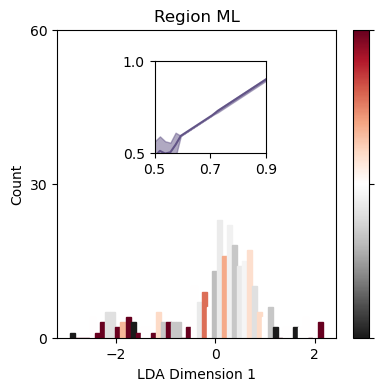

In [103]:
fbcf = 0.5

ntype = []
rfbc = rel_FBC_import

cutoff = np.quantile(rfbc, fbcf)
for n in range(rfbc.size):
    if rfbc[n] > cutoff:
        ntype.append(0)
    else:
        ntype.append(1)


lda = LinearDiscriminantAnalysis(n_components=1)
xtrans = lda.fit_transform(u, ntype)

carray = cm.RdGy(range(256))

# Color by type
fig, ax = plt.subplots(figsize=(4.5, 4))
N, bins, patches = ax.hist(xtrans, linewidth=1, bins=50)
xbinned = np.digitize(xtrans, bins).squeeze()
# Set each rectangle to a color gradient set by the fraction of entries that belong to each type
for i in range(len(patches)):
    x_ = np.where(xbinned == i + 1)[0]
    ntype_ = np.array(ntype)[x_]

    if x_.size == 0:
        frac = 0 # just ignore these, since these will have no height anyways
    else:
        frac = np.sum(ntype_)/x_.size

    patches[i].set_facecolor(carray[int(255 * frac)])
    patches[i].set_edgecolor(carray[int(255 * frac)])
    #patches[i].set_facecolor(carray[0])
ax.set_xlabel('LDA Dimension 1')
ax.set_ylabel('Count')
ax.set_xticks([-2, 0, 2])
ax.set_yticks([0, 30, 60])
cmap = cm.RdGy.reversed()
norm = colors.Normalize(vmin=0, vmax=1)
cbar= fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='', ticks=[0, 0.5, 1.0])
#cbar.ax.set_yticks([0, 0.5, 1.0])
cbar.ax.set_yticklabels([])
plt.title("Region ML")


axin = ax.inset_axes([0.35, 0.6, 0.4, 0.3])
# axin.set_aspect(1)
axin.set_ylim([0.5, 1.0])
axin.set_xlim([0.5, 0.9])
axin.set_yticks([0.5, 1.0])
axin.set_xticks([0.5, 0.7, 0.9])
axin.plot(fbc_fraction, np.mean(scores, axis=(1)), color='#625487')
axin.fill_between(fbc_fraction, np.mean(scores, axis=(1)) - np.std(scores, axis=(1)), np.mean(scores, axis=(1)) + np.std(scores, axis=(1)), alpha=0.5, color='#625487')

## Plotting waveforms

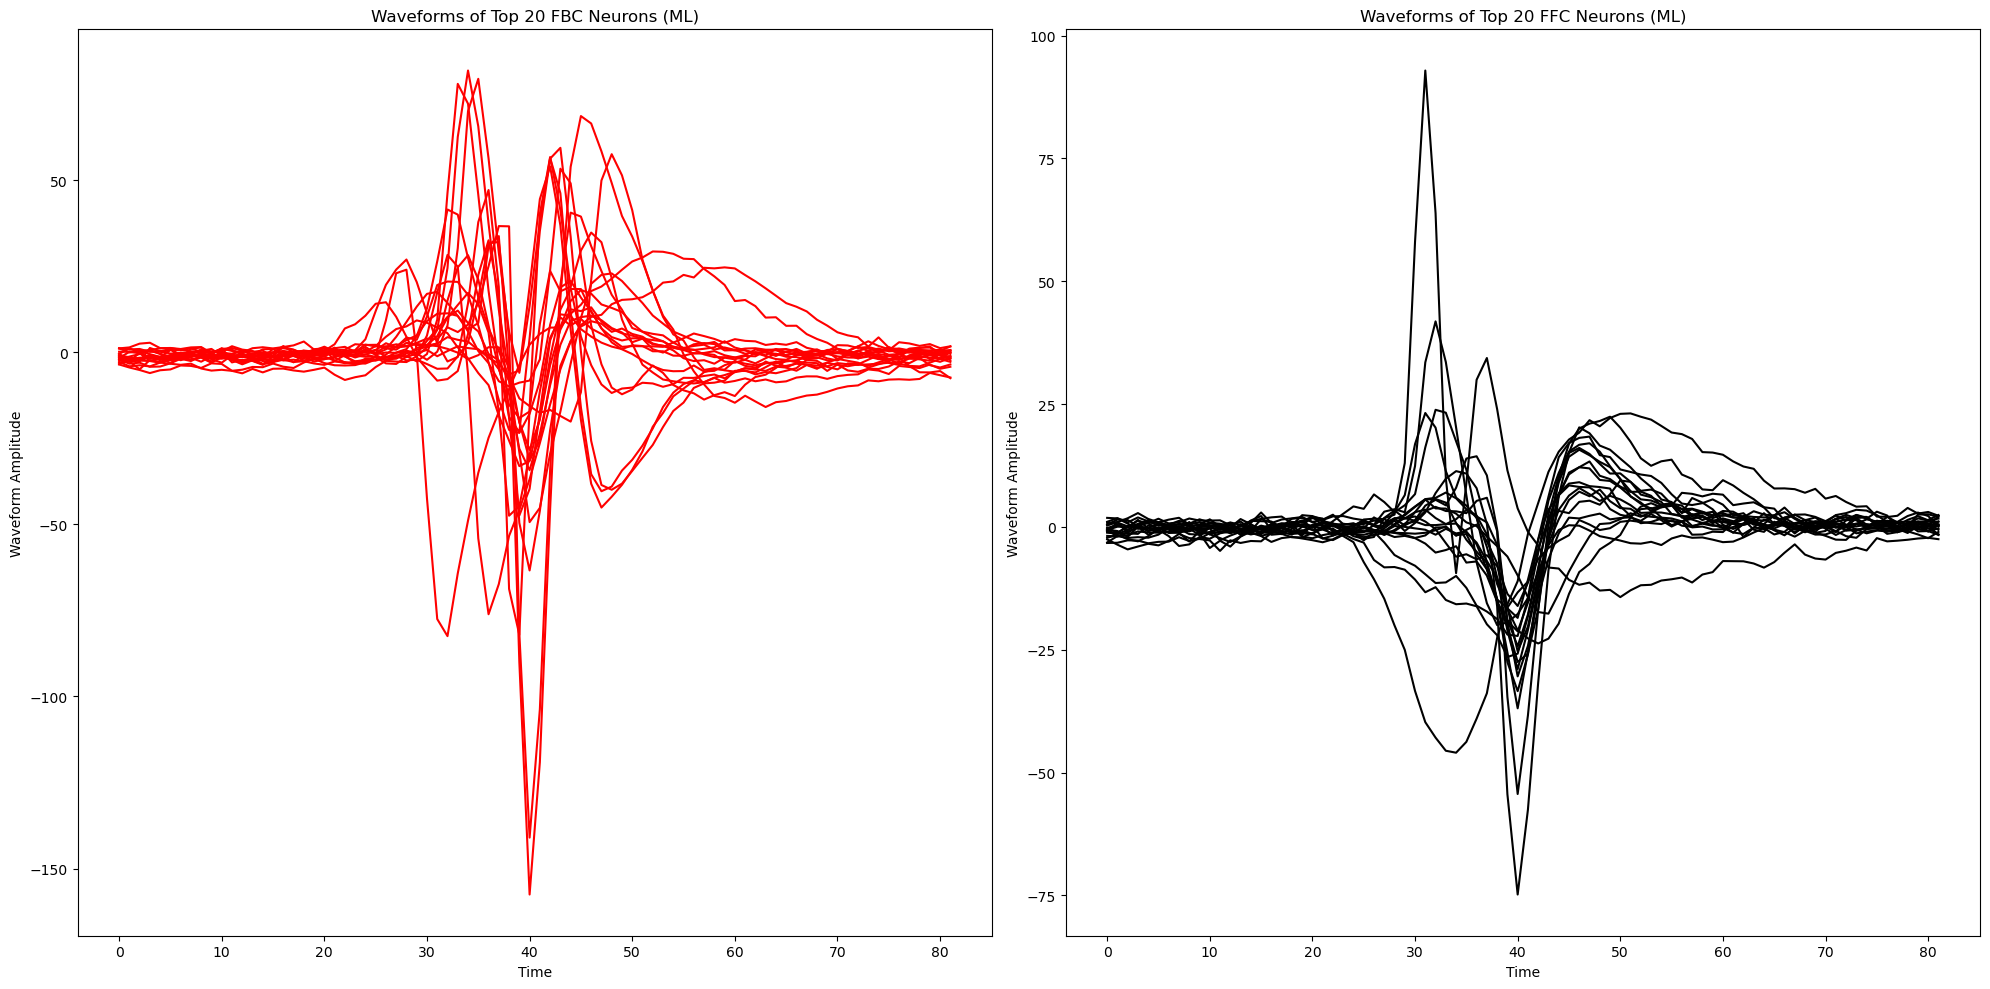

In [106]:
top_n_units = 20

ffc_scores_ml = importance_scores['ML']['PCA'][DIM]
fbc_scores_ml = importance_scores['ML']['LQGCA'][DIM]
ML_waveforms = ML_loaded_data['waveforms']

rel_fbc = fbc_scores_ml / (fbc_scores_ml + ffc_scores_ml)
rel_ffc = ffc_scores_ml / (fbc_scores_ml + ffc_scores_ml)

sort_vals_fbc = rel_fbc #fbc_scores_ml #
sort_vals_ffc = rel_ffc #ffc_scores_ml #

# Top 10 neurons by FBC importance
top_neurons_inds_fbc = np.argsort(sort_vals_fbc)[-top_n_units:][::-1]
top_waveforms_fbc = ML_waveforms[top_neurons_inds_fbc, :]
top_waveforms_fbc = top_waveforms_fbc - np.mean(top_waveforms_fbc, axis=1, keepdims=True)

# Top 10 neurons by FFC importance
top_neurons_inds_ffc = np.argsort(sort_vals_ffc)[-top_n_units:][::-1]
top_waveforms_ffc = ML_waveforms[top_neurons_inds_ffc, :]
top_waveforms_ffc = top_waveforms_ffc - np.mean(top_waveforms_ffc, axis=1, keepdims=True)

# Create the subplot
plt.figure(figsize=(20, 10))

# Plot for top 10 neurons by FBC importance
plt.subplot(1, 2, 1)
plt.title(f'Waveforms of Top {top_n_units} FBC Neurons (ML)')
for i in range(top_waveforms_fbc.shape[0]):
    plt.plot(top_waveforms_fbc[i], color='red') #, label=f'Neuron {top_neurons_inds_fbc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

# Plot for top 10 neurons by FFC importance
plt.subplot(1, 2, 2)
plt.title(f'Waveforms of Top {top_n_units} FFC Neurons (ML)')
for i in range(top_waveforms_ffc.shape[0]):
    plt.plot(top_waveforms_ffc[i], color='black') #, label=f'Neuron {top_neurons_inds_ffc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

plt.tight_layout()
plt.show()


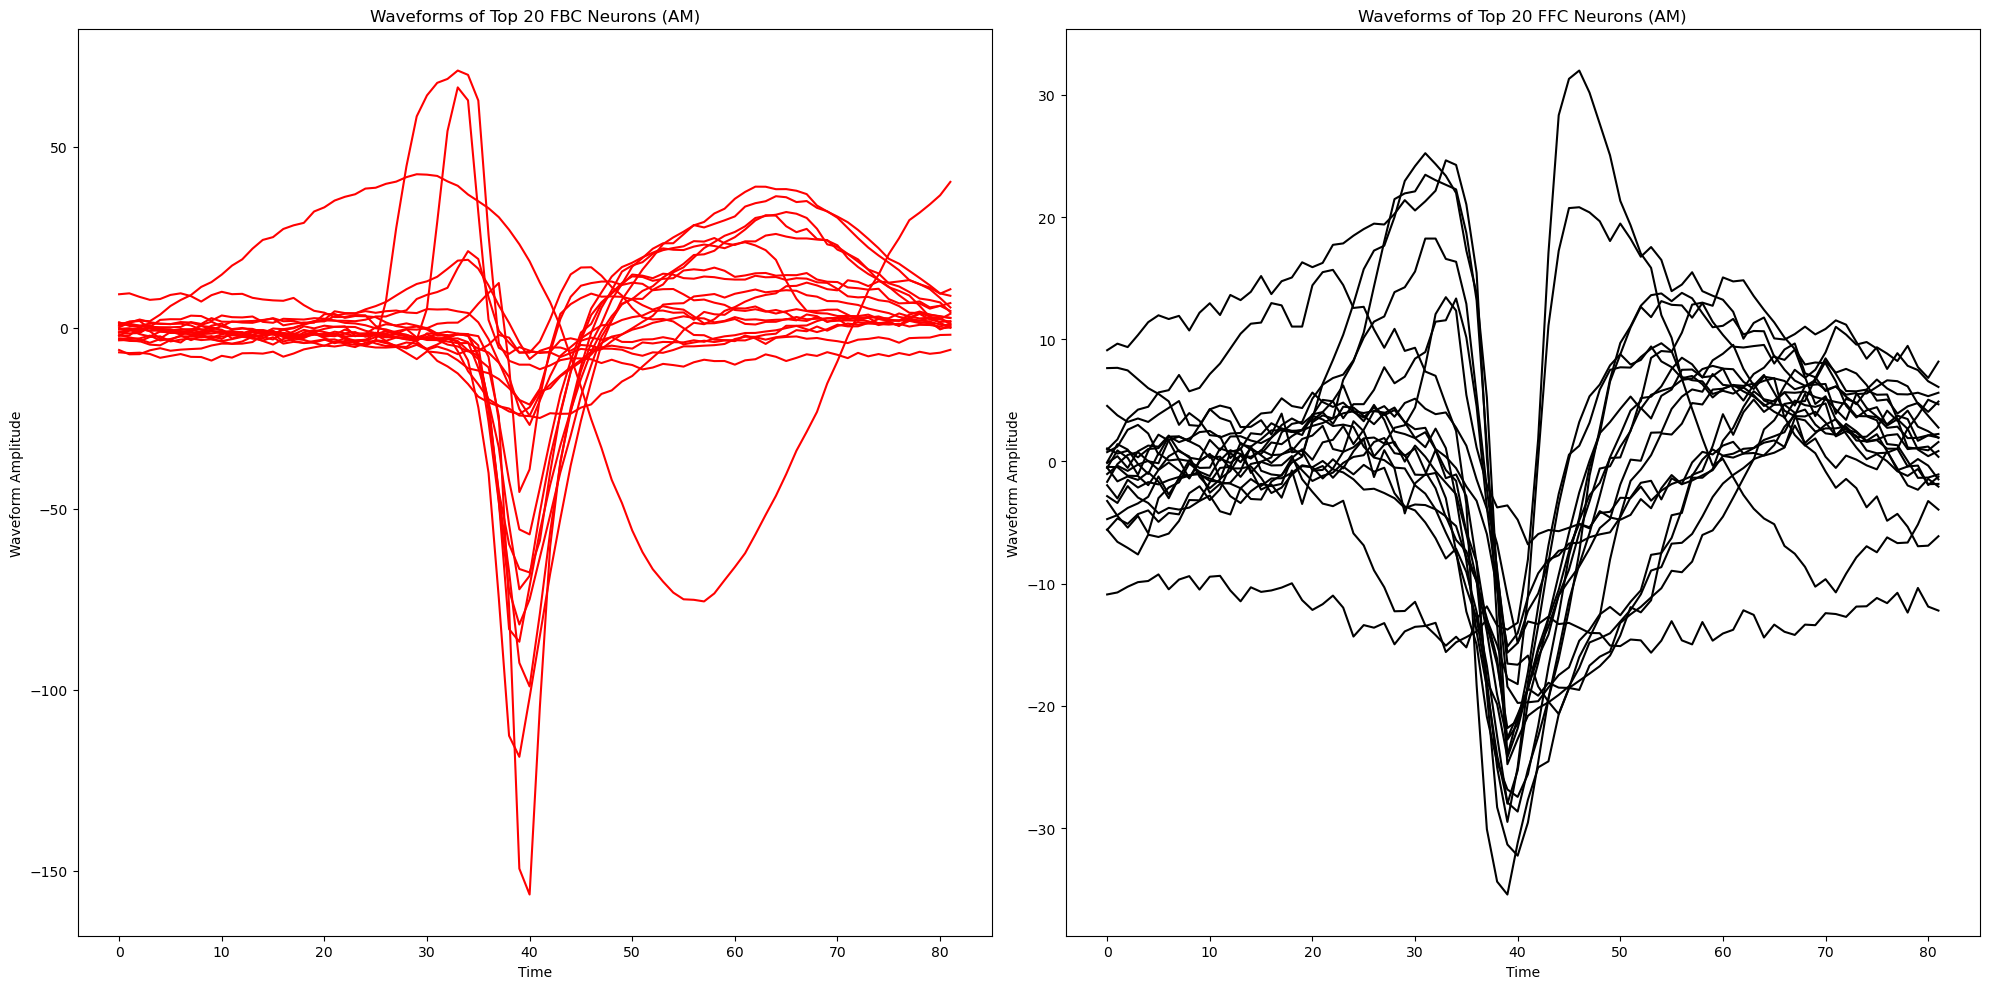

In [107]:
top_n_units = 20

ffc_scores_am = importance_scores['AM']['PCA'][DIM]
fbc_scores_am = importance_scores['AM']['LQGCA'][DIM]
AM_waveforms = AM_loaded_data['waveforms']

rel_fbc = fbc_scores_am / (fbc_scores_am + ffc_scores_am)
rel_ffc = ffc_scores_am / (fbc_scores_am + ffc_scores_am)

sort_vals_fbc = rel_fbc #fbc_scores_am #
sort_vals_ffc = rel_ffc #ffc_scores_am #

# Top 10 neurons by FBC importance
top_neurons_inds_fbc = np.argsort(sort_vals_fbc)[-top_n_units:][::-1]
top_waveforms_fbc = AM_waveforms[top_neurons_inds_fbc, :]
top_waveforms_fbc = top_waveforms_fbc - np.mean(top_waveforms_fbc, axis=1, keepdims=True)

# Top 10 neurons by FFC importance
top_neurons_inds_ffc = np.argsort(sort_vals_ffc)[-top_n_units:][::-1]
top_waveforms_ffc = AM_waveforms[top_neurons_inds_ffc, :]
top_waveforms_ffc = top_waveforms_ffc - np.mean(top_waveforms_ffc, axis=1, keepdims=True)

# Create the subplot
plt.figure(figsize=(20, 10))

# Plot for top 10 neurons by FBC importance
plt.subplot(1, 2, 1)
plt.title(f'Waveforms of Top {top_n_units} FBC Neurons (AM)')
for i in range(top_waveforms_fbc.shape[0]):
    plt.plot(top_waveforms_fbc[i], color='red') #, label=f'Neuron {top_neurons_inds_fbc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

# Plot for top 10 neurons by FFC importance
plt.subplot(1, 2, 2)
plt.title(f'Waveforms of Top {top_n_units} FFC Neurons (AM)')
for i in range(top_waveforms_ffc.shape[0]):
    plt.plot(top_waveforms_ffc[i], color='black') #, label=f'Neuron {top_neurons_inds_ffc[i]}')
plt.xlabel('Time')
plt.ylabel('Waveform Amplitude')
#plt.legend()

plt.tight_layout()
plt.show()
